# Tohoku tsunami inversion part I
### Sensitivity of timeseries mismatch QoI to initial surface

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions

Misc plotting routines

In [4]:
def plot_mesh(mesh2d, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    return axes

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        plot_field(field, fig, axes[i])
    return axes

Define a mesh and a Taylor-Hood space upon it.

__Notes__
  * The boundary is separated into three segments $\Gamma_{100}$, $\Gamma_{200}$ and $\Gamma_{300}$ corresponding to the (artificial) ocean boundary, coastal regions outside the locality of Fukushima and coastal regions near to Fukushima, respectively.
  * The mesh hierarchy (generated using qmesh) has five levels with each having approximately four times as many elements as the previous.

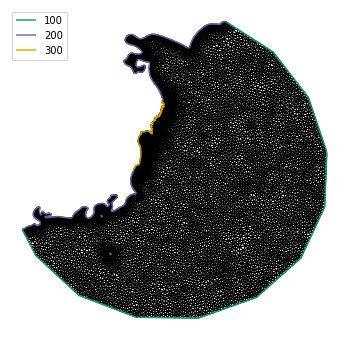

In [7]:
# level = 0
level = 1
# level = 2
op = TohokuOptions(level=level)
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1
plot_mesh(mesh);

Define fields for forward model

* Initial surface computed via inversion analysis in __[Saito et al. 2011]__.
* Bathymetry from GEBCO.

In [8]:
eta_init = Function(P1, name="Initial surface").assign(op.set_initial_surface(P1))
b = Function(P1, name="Bathymetry").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))

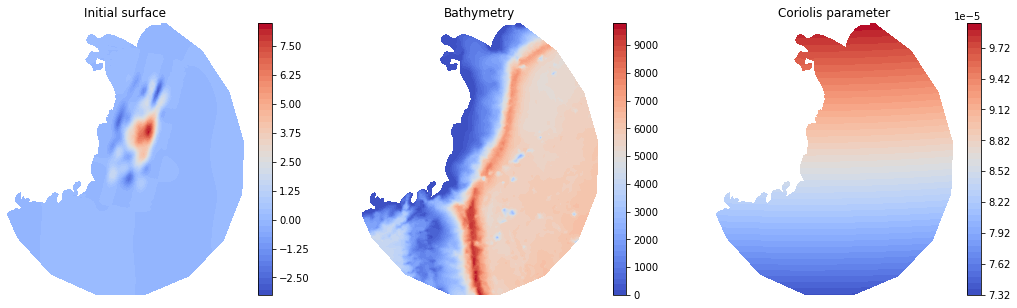

In [9]:
plot_fields(eta_init, b, f);

Hand-coded Crank-Nicolson / Taylor-Hood solver for shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0
$$
equipped with boundary conditions
$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\partial\Omega}\equiv0\qquad
    \eta|_{\Gamma_{100}}\equiv0.
$$

In [10]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()
eta.dat.name = "Final surface"

bc = DirichletBC(TaylorHood.sub(1), 0, 100)

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bc)
solver = LinearVariationalSolver(problem, solver_parameters=params)

Consider a time-dependent quantity of interest (QoI) which measures the goodness-of-fit at gauges
$$
J(\mathbf u,\eta)=\sum_{t\in\mathcal T}\sum_{g\in\mathcal G}\big|\:\eta(\mathbf x_g,t)-\eta_g(t)\:\big|,
$$
where $\mathcal T\subset(0, T]$ is a finite set of time levels and $\mathcal G\subset\Omega$ is a finite set of gauge coordinates.
For a given gauge $g$, $\eta_g(t)$ is the observed free surface height at time $t$ and $\mathbf x_g$ provides the UTM coordinates.

In order to evaluate such a QoI we first need to be able to represent the elevation at each gauge in $\mathcal H^1(\Omega)$.
Our approach is to use indicator functions of as narrow a radius as we can get away with.

In [11]:
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    x, y = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(op.ball(mesh, custom_locs=[(x, y, radius), ]), P0)

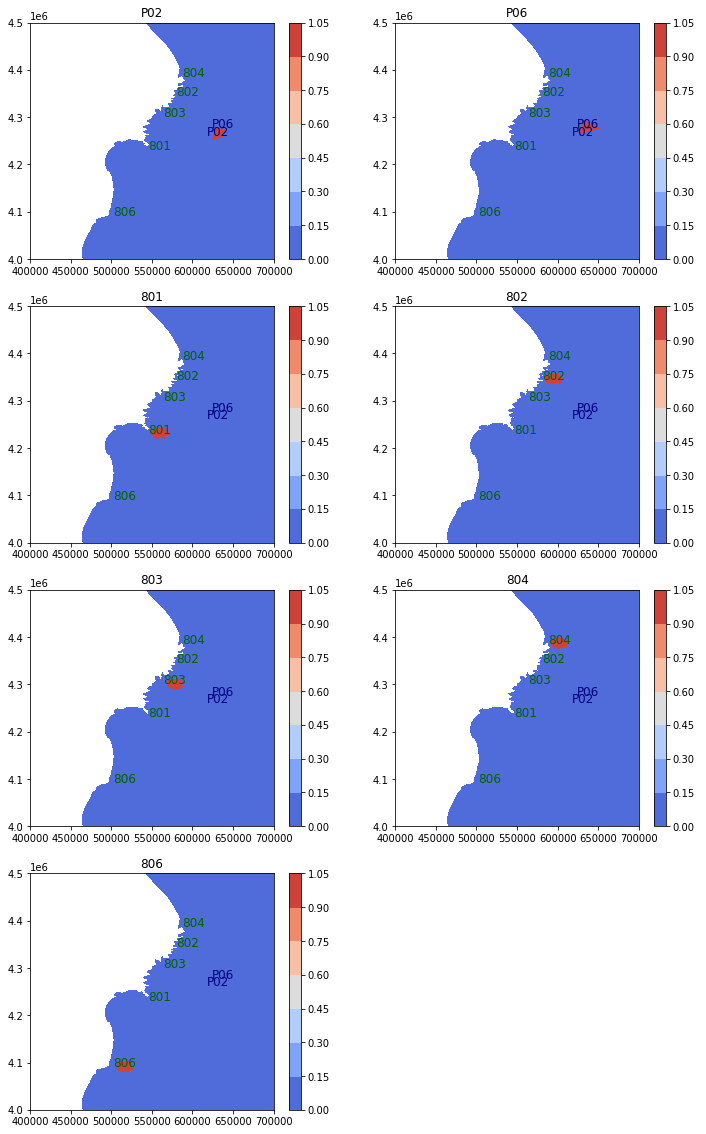

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12, 20))
for i, gauge in enumerate(gauges):
    ax = axes[i//2, i%2]
    fig.colorbar(tricontourf(op.gauges[gauge]['indicator'], axes=ax, cmap='coolwarm'), ax=ax);
    ax.set_xlim([0.4e+06, 0.7e+06]);
    ax.set_ylim([4.0e+06, 4.5e+06]);
    ax.set_title(gauge)
    op.annotate_plot(ax, coords='utm', gauges=True)
axes[3, 1].axis(False);

Next we need timeseries data at the gauges. (See notebook `resources/gauges/plot_gauge_data.ipynb`.)

__Notes__
  * We have done some averaging over samples in order to reduce noise.
  * The GPS gauges 801-806 contain `NaN`s.

In [13]:
def read_and_sample(g, sample=1):
    """Copied from `resources/gauges/plot_gauge_data.ipynb`"""
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t = []
    d = []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        running = 0
        for i in range(num_lines):
            line = f.readline()
            time, dat = line.split()
            time = float(time)
            dat = float(dat)
            running += dat
            if i % sample == 0 and i > 0:
                if time < time_prev:
                    break  # FIXME
                t.append(0.5*(time + time_prev))
                d.append(running/sample)
                running = 0
                time_prev = time
    return t, d

In [14]:
for gauge in gauges:
    sample = 60 if gauge[0] == 'P' else 12
    op.gauges[gauge]['times'], op.gauges[gauge]['data'] = read_and_sample(gauge, sample=sample)

Note that the GPS gauges contain one extra data point (at the end) than the pressure gauges, but are otherwise evaluated at the same times.

In [15]:
times = np.array(op.gauges['P02']['times'])
n = len(times)
for gauge in op.gps_gauges:
    op.gauges[gauge]['data'] = op.gauges[gauge]['data'][:-1]
for gauge in op.gauges:
    assert len(op.gauges[gauge]['data']) == n

Following __[Saito et al. 2011]__, subtract the initial elevation at each gauge:

In [16]:
for gauge in gauges:
    for i in range(n):
        if not np.isnan(op.gauges[gauge]['data'][i]):
            op.gauges[gauge]['data'] = np.array(op.gauges[gauge]['data']) - op.gauges[gauge]['data'][i]
            break

Now run the forward model, time integrating the QoI as time progresses.

In [17]:
t = 0.0
i = 0
J = 0
i_obs = 0
# op.end_time = 3600.0
op.end_time = 1440.0  # TODO: TEMPORARY
t_obs = Constant(op.end_time / len(times))
eta_.assign(eta_init)
control = Control(q_)
with stop_annotating():
    for gauge in gauges:
        op.gauges[gauge]['diff'] = []
        op.gauges[gauge]['timeseries'] = []
        op.gauges[gauge]['diff_smooth'] = []
        op.gauges[gauge]['init'] = None
        op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx)
while t < op.end_time:
    solver.solve()
    
    # Time integrate QoI
    #   NOTE: The quadrature scheme matching Crank-Nicolson is the trapezium rule
    if np.allclose(t, times[i_obs]):
        print("observation {:2d} (t = {:.2f})".format(i_obs, t))
        weight = 1.0
        if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt:
            weight = 0.5
        u, eta = q.split()
        for gauge in op.gauges:
            eta_discrete = eta.at(op.gauges[gauge]["coords"])
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta_discrete
            eta_discrete -= op.gauges[gauge]['init']
            op.gauges[gauge]['timeseries'].append(eta_discrete)
            eta_obs = op.gauges[gauge]['data'][i_obs]
            if not np.isnan(eta_obs):
                
                # Discrete form
                diff = abs(eta_discrete - eta_obs)
                op.gauges[gauge]['diff'].append(diff)
#                 J += weight*t_obs*diff

                # Continuous form
                diff = op.gauges[gauge]['indicator']*abs(eta - eta_obs)
                J_inc = assemble(weight*t_obs*diff*dx)
                J += J_inc
                with stop_annotating():
                    op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx)/op.gauges[gauge]['area'])
            else:
                op.gauges[gauge]['diff'].append(np.nan)
                op.gauges[gauge]['diff_smooth'].append(np.nan)
        i_obs += 1
        
        
    q_.assign(q)
    t += op.dt
    i += 1
    if i_obs == len(times):
        break
print("Quantity of interest = {:.4e}".format(J))

observation  0 (t = 30.00)
observation  1 (t = 90.00)
observation  2 (t = 150.00)
observation  3 (t = 210.00)
observation  4 (t = 270.00)
observation  5 (t = 330.00)
observation  6 (t = 390.00)
observation  7 (t = 450.00)
observation  8 (t = 510.00)
observation  9 (t = 570.00)
observation 10 (t = 630.00)
observation 11 (t = 690.00)
observation 12 (t = 750.00)
observation 13 (t = 810.00)
observation 14 (t = 870.00)
observation 15 (t = 930.00)
observation 16 (t = 990.00)
observation 17 (t = 1050.00)
observation 18 (t = 1110.00)
observation 19 (t = 1170.00)
observation 20 (t = 1230.00)
observation 21 (t = 1290.00)
observation 22 (t = 1350.00)
observation 23 (t = 1410.00)
Quantity of interest = 7.4413e+11


Compare initial and final solution

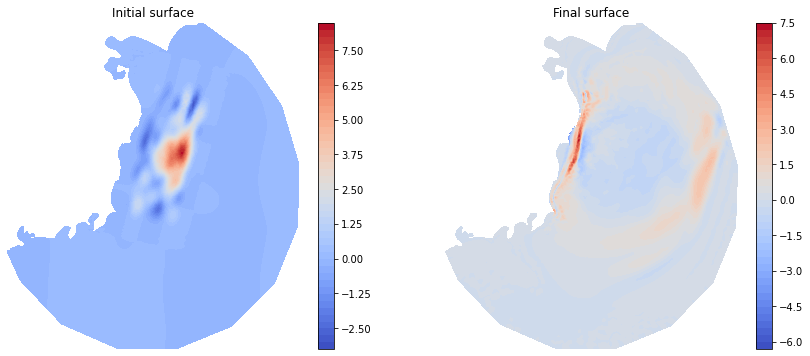

In [18]:
axes = plot_fields(eta_init, eta, height=6)

Let's compare the point evaluated (discrete) elevation field with the gauge timeseries data:

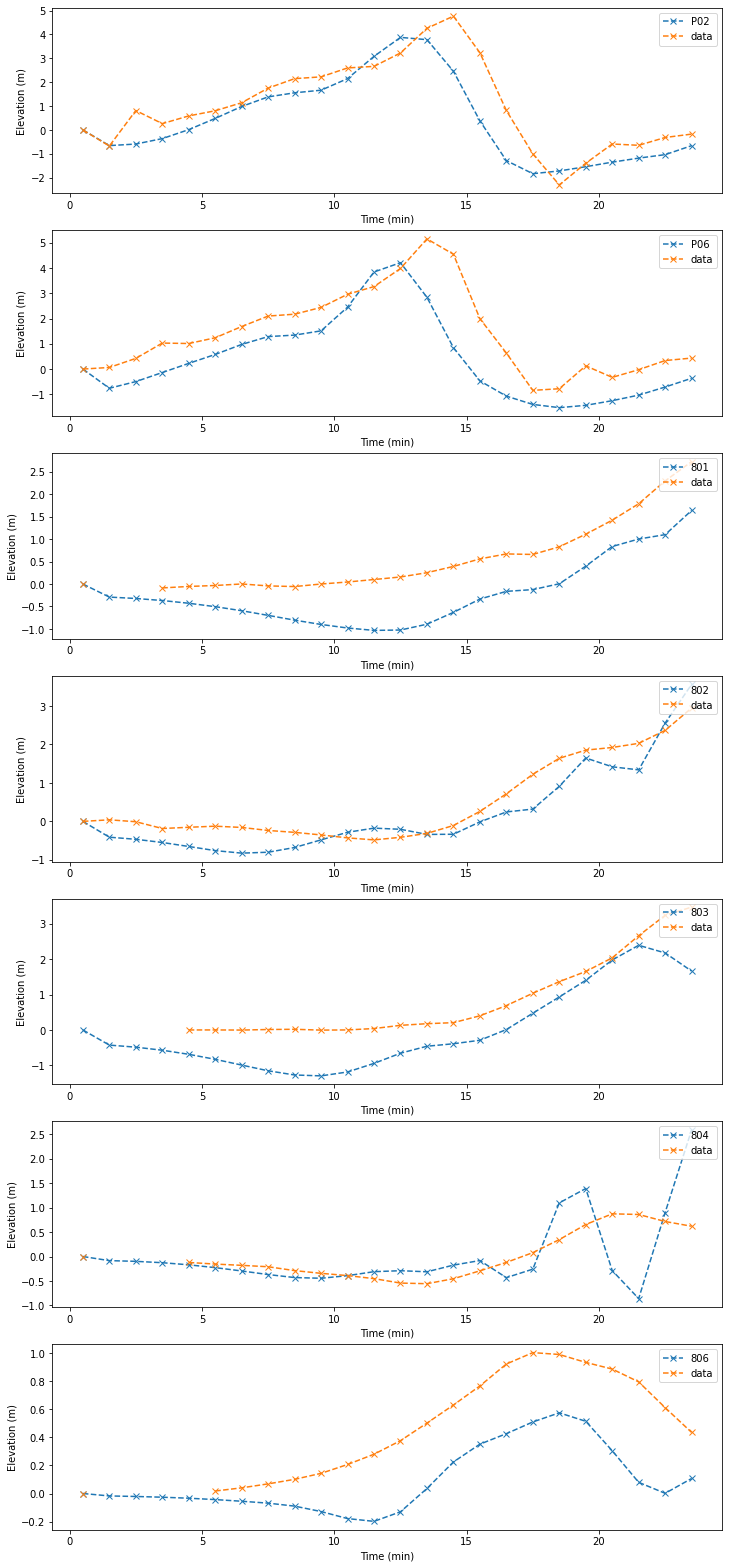

In [19]:
gauges = list(op.gauges.keys())
n = len(gauges)
fig, axes = plt.subplots(nrows=n, figsize=(12, 4*n))
for i, gauge in enumerate(gauges):
    N = len(op.gauges[gauge]['timeseries'])
    axes[i].plot(times[:N]/60, op.gauges[gauge]['timeseries'], '--x', label=gauge)
    axes[i].plot(times[:N]/60, op.gauges[gauge]['data'][:N], '--x', label='data')
    axes[i].legend(loc='upper right')
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel('Elevation (m)')

Let's check that the indicator function approach provides timeseries which approximate the discrete versions:

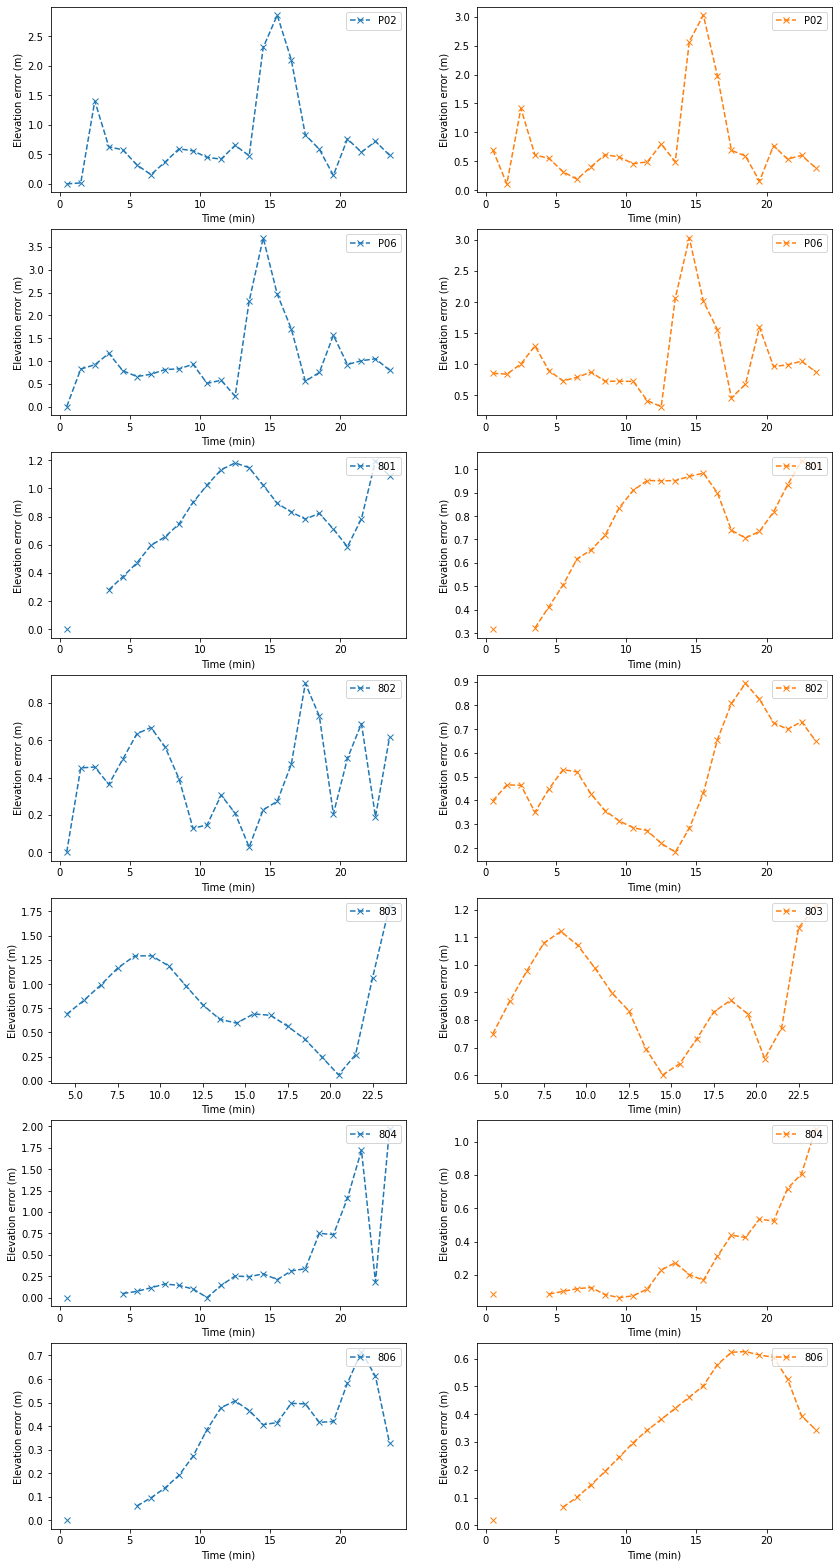

In [20]:
n = len(gauges)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 4*n))
for i, gauge in enumerate(gauges):
    
    N = len(op.gauges[gauge]['diff'])
    axes[i, 0].plot(times[:N]/60, op.gauges[gauge]['diff'], '--x', label=gauge)
    axes[i, 0].legend(loc='upper right')
    axes[i, 0].set_xlabel('Time (min)')
    axes[i, 0].set_ylabel('Elevation error (m)')
    
    N = len(op.gauges[gauge]['diff_smooth'])
    axes[i, 1].plot(times[:N]/60, op.gauges[gauge]['diff_smooth'], '--x', color='tab:orange', label=gauge)
    axes[i, 1].legend(loc='upper right')
    axes[i, 1].set_xlabel('Time (min)')
    axes[i, 1].set_ylabel('Elevation error (m)')

We observe that the correspondence between the discrete and continuous forms of the error improves with mesh resolution.

Compute gradient w.r.t. initial condition

In [21]:
with stop_annotating():
    dJdic = compute_gradient(J, control)
    dJdic_u, dJdic_eta = dJdic.split()
    dJdic_u.dat.name = "Sensitivity of QoI to initial velocity"
    dJdic_eta.dat.name = "Sensitivity of QoI to initial surface"

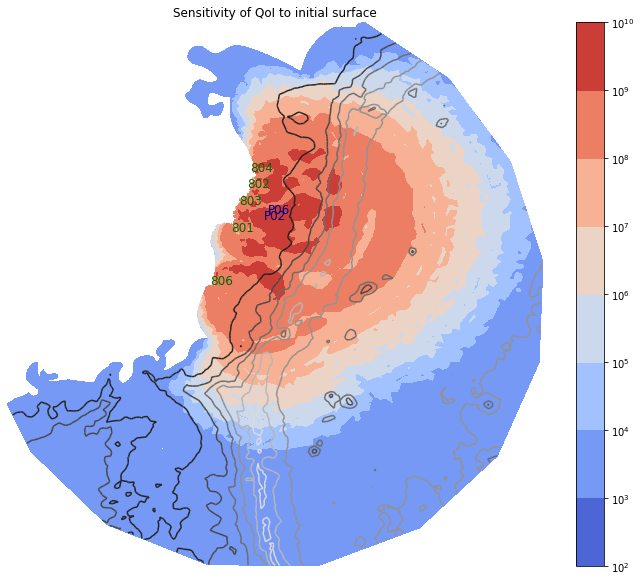

In [22]:
# axes = plot_field(dJdic_eta, height=10)
with stop_annotating():
    dJdic_eta_positive = Function(P1, name=dJdic_eta.dat.name)
    dJdic_eta_positive.interpolate(max_value(abs(dJdic_eta), 1.0e+03))
    axes = plot_field(dJdic_eta_positive, height=10, locator=matplotlib.ticker.LogLocator())
    op.annotate_plot(axes, gauges=True, coords="utm")
    tricontour(b, axes=axes, cmap='gray');

As can be expected, the sensitivity of the QoI to the initial elevation is significant near to the gauges and negligible in the far field.
It is also sensitive in the tsunami source region.

In order to invert for the initial condition we need to do two things:
  1. Represent the initial free surface in some basis with constant coefficients $\{m_i\}_i$ multiplying each basis function.
  2. Express the QoI $J=J(\mathbf u,\eta;\mathbf m)$ as a reduced functional, $\hat J=\hat J(\mathbf m)$.
  3. Pass the gradient and $\hat J$ to a gradient based optimisation routine.